In [0]:
!pip install q keras==2.1.5

     |████████████████████████████████| 337kB 7.7MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import Ipynb_importer
import keras
# from tensorflow import keras
from keras import backend as K
from keras.optimizers import Optimizer
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.models import Sequential
import numpy as np
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from optimizers import MaSS
from cifar10 import load
from resnet import resnet_v1, resnet_v2
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0,1" 

Using TensorFlow backend.


In [0]:
tf.__version__

'1.15.2'

In [0]:
keras.__version__

'2.1.5'

In [0]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,1" 
batch_size = 64
epochs = 100
data_augmentation = True
num_classes = 10
learning_rate=0.01
# Load Cifar-10 data
(x_train, y_train), (x_test, y_test) = load()
input_shape = x_train.shape[1:]

# Model parameters
n = 5
version = 1
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
##############################################################################
#CNN
class Lenet:
  def neural(channel,height,width,classes):
      input_shape = (channel,height,width)
      if K.image_data_format() == "channels_last":
          input_shape = (height,width,channel)
      model = Sequential()
      model.add(Conv2D(64,(5,5),padding="same",activation="relu",input_shape=input_shape,name="conv1"))
      model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name="pool1"))

      model.add(Conv2D(64,(5,5),padding="same",activation="relu",name="conv2",))
      model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name="pool2"))

      model.add(Conv2D(128,(5,5),padding="same",activation="relu",name="conv3",))
      model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name="pool3"))

      model.add(Flatten())
      model.add(Dense(128,activation="relu",name="fc1"))
      model.add(Dense(classes,activation="softmax",name="fc2"))
      return model
################################################################
#仅测试resNet 50 epochs
################################################################
# Build model
channel = 3
height = 32
width = 32
class_num = 10
norm_size = 32

model = Lenet.neural(channel=channel, height=height,width=width, classes=class_num)#网络
# model = resnet_v1(input_shape=input_shape, depth=depth)
mass = MaSS(lr = learning_rate, alpha = 0.05, kappa_t = 2)
model.compile(loss='categorical_crossentropy',
              optimizer=mass,
              metrics=['accuracy'])
model.summary()

# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model_mass.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=False)
callbacks = [checkpoint]

# Training
if not data_augmentation:
    result1 = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')

    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,           	# set input mean to 0 over the dataset
        samplewise_center=False,            	# set each sample mean to 0        
        featurewise_std_normalization=False,    # divide inputs by std of dataset        
        samplewise_std_normalization=False,     # divide each input by its std
        zca_whitening=False,                    # apply ZCA whitening        
        rotation_range=0,                       # randomly rotate images in the range (deg 0 to 180)        
        width_shift_range=0.1,                  # randomly shift images horizontally        
        height_shift_range=0.1,                 # randomly shift images vertically        
        horizontal_flip=True,                   # randomly flip images        
        vertical_flip=False)                    # randomly flip images

    res1 = datagen.fit(x_train)
    # Fit the model on the batches generated by datagen.flow().
    result1 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                                 callbacks=callbacks)

Load CIFAR-10 dataset.
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 64)        4864      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        102464    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 128)         204928    
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 4, 4, 128)         0         
____________________

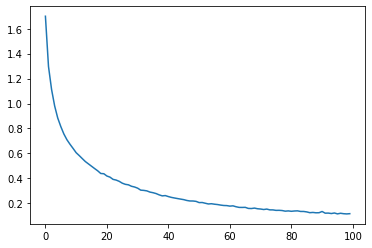

In [0]:
import matplotlib.pyplot as plt
 
plt.plot(result1.history['loss'])

In [0]:
# model = resnet_v1(input_shape=input_shape, depth=depth)
model = Lenet.neural(channel=channel, height=height,width=width, classes=class_num)#网络
mass = MaSS(lr = learning_rate, alpha = 0.05, kappa_t = 6)
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=learning_rate),
              metrics=['accuracy'])
model.summary()

# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model_mass.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=False)
callbacks = [checkpoint]

# Training
if not data_augmentation:
    result2 = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')

    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,           	# set input mean to 0 over the dataset
        samplewise_center=False,            	# set each sample mean to 0        
        featurewise_std_normalization=False,    # divide inputs by std of dataset        
        samplewise_std_normalization=False,     # divide each input by its std
        zca_whitening=False,                    # apply ZCA whitening        
        rotation_range=0,                       # randomly rotate images in the range (deg 0 to 180)        
        width_shift_range=0.1,                  # randomly shift images horizontally        
        height_shift_range=0.1,                 # randomly shift images vertically        
        horizontal_flip=True,                   # randomly flip images        
        vertical_flip=False)                    # randomly flip images

    res2 = datagen.fit(x_train)
    # Fit the model on the batches generated by datagen.flow().
    result2 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                                 callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 64)        4864      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        102464    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 128)         204928    
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
__________

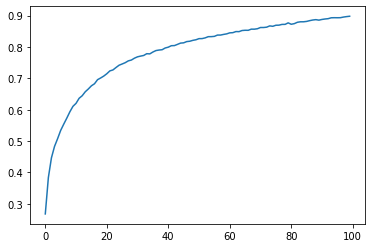

In [0]:
import matplotlib.pyplot as plt
# 上升可能是因为学习率太大
plt.plot(result2.history['acc'])

In [0]:
# model = resnet_v1(input_shape=input_shape, depth=depth)
model = Lenet.neural(channel=channel, height=height,width=width, classes=class_num)#网络
mass = MaSS(lr = learning_rate, alpha = 0.05, kappa_t = 2)
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=learning_rate,momentum=0.9,nesterov=True),
              metrics=['accuracy'])
model.summary()

# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model_mass.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=False)
callbacks = [checkpoint]

# Training
if not data_augmentation:
    result3 = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')

    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,           	# set input mean to 0 over the dataset
        samplewise_center=False,            	# set each sample mean to 0        
        featurewise_std_normalization=False,    # divide inputs by std of dataset        
        samplewise_std_normalization=False,     # divide each input by its std
        zca_whitening=False,                    # apply ZCA whitening        
        rotation_range=0,                       # randomly rotate images in the range (deg 0 to 180)        
        width_shift_range=0.1,                  # randomly shift images horizontally        
        height_shift_range=0.1,                 # randomly shift images vertically        
        horizontal_flip=True,                   # randomly flip images        
        vertical_flip=False)                    # randomly flip images

    res3 = datagen.fit(x_train)
    # Fit the model on the batches generated by datagen.flow().
    result3 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                                 callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 64)        4864      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        102464    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 128)         204928    
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
__________

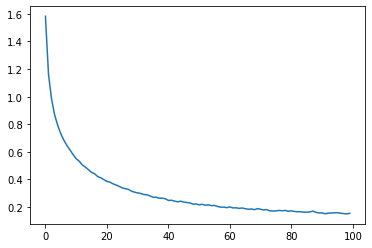

In [0]:
import matplotlib.pyplot as plt

plt.plot(result3.history['loss'])

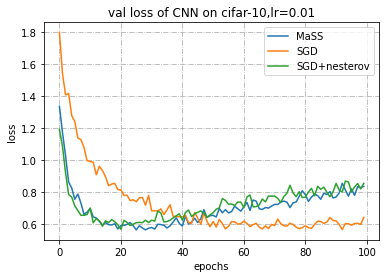

In [0]:
plt.plot(result1.history['val_loss'],label='MaSS')
plt.plot(result2.history['val_loss'],label='SGD')
plt.plot(result3.history['val_loss'],label='SGD+nesterov')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("val loss of CNN on cifar-10,lr=0.01")
plt.grid(linestyle='-.')
plt.legend()
plt.show() 

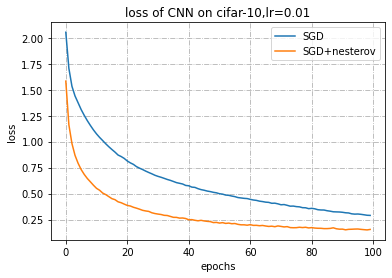

In [0]:
# plt.plot(result1.history['loss'],label='MaSS')
plt.plot(result2.history['loss'],label='SGD')
plt.plot(result3.history['loss'],label='SGD+nesterov')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("loss of CNN on cifar-10,lr=0.01")
plt.grid(linestyle='-.')
plt.legend()
plt.show() 

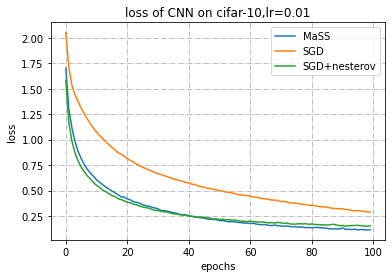

In [0]:
plt.plot(result1.history['loss'],label='MaSS')
plt.plot(result2.history['loss'],label='SGD')
plt.plot(result3.history['loss'],label='SGD+nesterov')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("loss of CNN on cifar-10,lr=0.01")
plt.grid(linestyle='-.')
plt.legend()
plt.show() 

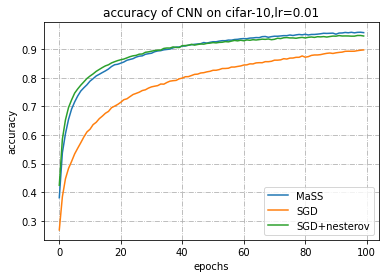

In [0]:
plt.plot(result1.history['acc'],label='MaSS')
plt.plot(result2.history['acc'],label='SGD')
plt.plot(result3.history['acc'],label='SGD+nesterov')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("accuracy of CNN on cifar-10,lr=0.01")
plt.grid(linestyle='-.')
plt.legend()
plt.show()

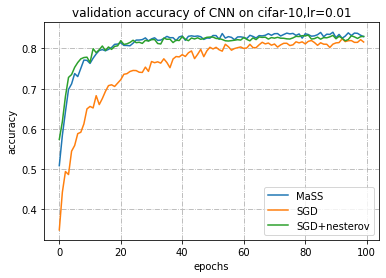

In [0]:
plt.plot(result1.history['val_acc'],label='MaSS')
plt.plot(result2.history['val_acc'],label='SGD')
plt.plot(result3.history['val_acc'],label='SGD+nesterov')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("validation accuracy of CNN on cifar-10,lr=0.01")
plt.grid(linestyle='-.')
plt.legend()
plt.show()

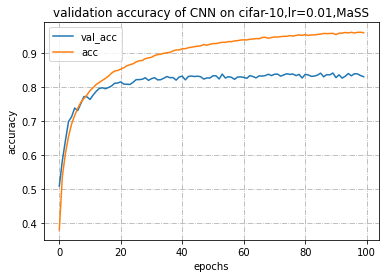

In [0]:
plt.plot(result1.history['val_acc'],label='val_acc')
plt.plot(result1.history['acc'],label='acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("validation accuracy of CNN on cifar-10,lr=0.01,MaSS")
plt.grid(linestyle='-.')
plt.legend()
plt.show()